# Импорты и подготовка данных

Так как нам даны табличные данные, а на табличных данных лучше всего работают различные модели бустинга, то выберем одну из наиболее популярных и удобных в использовании реализаций: **CatBoost**.

In [ ]:
!pip install -q catboost

     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_score, recall_score, plot_confusion_matrix
from os import listdir
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Один раз распакуем zip-архив на гугл-диск. В дальнейшем не будем использовать эту ячейку.

In [ ]:
# import zipfile 
# zip_file = '/content/drive/My Drive/BestHack/transactions.zip'
# zip_file = zipfile.ZipFile(zip_file, "r")
# zip_file.extractall('/content/drive/My Drive/BestHack/')

Создадим отсортированнный массив названий файлов из датасета

In [ ]:
names = listdir('/content/drive/My Drive/BestHack/transactions/')
names = sorted(names)

Напишем функцию, которая выдает с гугл-диска данные из выбранного интервала времени(дни)

In [ ]:
def get_first_n_days(n, start=0, names=names):
    df_target = pd.read_csv('/content/drive/My Drive/BestHack/target.csv')
    df_target = df_target.rename(columns={"id": "id_a"})
    df_train = []
    for i in tqdm(range(start, start+n)):
        df_i = pd.read_csv('/content/drive/My Drive/BestHack/transactions/'+names[i])
        df_train_i = pd.merge(df_i, df_target).dropna()
        df_train_i.drop('split', axis=1, inplace=True)
        df_train_i['hour'] = pd.to_datetime(df_train_i['start_time_local'], format="%H:%M:%S").dt.hour
        df_train_i['minutes'] = pd.to_datetime(df_train_i['start_time_local'], format="%H:%M:%S").dt.minute
        df_train_i['minutes'] += 60*df_train_i['hour']
        df_train_i.drop('hour', axis=1, inplace=True)
        df_train_i.drop('start_time_local', axis=1, inplace=True)
        df_train_i['dayofweek'] = pd.to_datetime(df_train_i['time_key']).dt.dayofweek
        df_train_i.drop('time_key', axis=1, inplace=True)
        df_train_i.drop('num_b_length', axis=1, inplace=True)
        df_train.append(df_train_i)
    return pd.concat(df_train)

# Визуализация до обучения моделей

##Матрица корреляций

Здесь посмотрим на correlation matrix для исходных фичей на первом дне. Так как год, месяц и день для 1 файла=1 дня совпадают, исключим их из фичей.

In [1]:
df_train = get_first_n_days(1)
df_train = df_train.drop("year", axis=1)
df_train = df_train.drop("month", axis=1)
df_train = df_train.drop("day", axis=1)
df_train = df_train.drop("target", axis=1)
df_target = pd.read_csv('/content/drive/My Drive/BestHack/target.csv')
df_target = df_target.rename(columns={"id": "id_a"})
df_train = pd.merge(df_train, df_target).dropna()
f = plt.figure(figsize=(12, 12))
plt.matshow(df_train.corr(), fignum=f.number)
plt.xticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=16, rotation=90)
plt.yticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=16)
cb = plt.colorbar()
plt.title("Матрица корреляций", fontsize=25, pad=100)
cb.ax.tick_params(labelsize=14)

NameError: ignored

**Выводы:** фичи имеют малую корреляцию с таргетом. Однако среди фичей выделяется группа "forward", "zero_call_flg", "source_b" имеющие сильную положительную корреляцию между собой и "source_f" имеющая сильную отрицательную корреляцию с предыдущими тремя. Очевидно, обе фичи обозначают источник, откуда пришел вызов и являются противоположностями. Судя по всему, вызовы, которые имеют нулевую длительность, вызовы с переадресацией и вызовы из источника source_b связанны между собой, однако из-за отсутствия более подробной технической информации о данных фичах назвать причину этого затруднительно.

Также заметно, что часы, минуты и секунды слабо коррелируют с таргетом, поробуем это исправить.

## Матрица корреляций после убирания маловажных фичей(секунды, месяц, год и num_b_length) и добавления новых(день недели, время в минутах от начала дня)

Проведем feature engineering и построим correalation matrix на новых фичах.

In [ ]:
df_train = get_first_n_days(7)
df_train = df_train.drop("target", axis=1)
df_target = pd.read_csv('/content/drive/My Drive/BestHack/target.csv')
df_target = df_target.rename(columns={"id": "id_a"})
df_train = pd.merge(df_train, df_target).dropna()
f = plt.figure(figsize=(12, 12))
plt.matshow(df_train.corr(), fignum=f.number)
plt.xticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=16, rotation=90)
plt.yticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=16)
cb = plt.colorbar()
plt.title("Матрица корреляций", fontsize=25, pad=100)
cb.ax.tick_params(labelsize=14)

**Вывод:** Так же, как и раньше, есть блок из 4 сильно скоррелированных фичей. Теперь после замены даты на день недели и времени в формате HH:MM:SS на время от начала дня в минутах, все фичи имеют некоторую корреляцию с таргетом и в дальнейшем будет показана их важность для моделей(feature_importance).

## Доля звонков от разных категорий пользователей

Посмотрим как зависит частота звонков разных типов пользователей от дня. В дальнейшем красными точками будем обозначать праздники 4 и 5 ноября и 30 и 31 декабря. Зелеными токчми будем обозначать выходные дни - субботы и воскресенья.

In [ ]:
target_statistics = [] 
df_target = pd.read_csv('/content/drive/My Drive/BestHack/target.csv')
df_target = df_target.rename(columns={"id": "id_a"})
for i in tqdm(range(len(names))):
    df = pd.read_csv('/content/drive/My Drive/BestHack/transactions/'+names[i])
    df_train = pd.merge(df, df_target).dropna()
    target_stat = df_train.target.value_counts().values
    target_statistics.append(target_stat/target_stat.sum())

In [ ]:
import seaborn as sns
sns.set(font_scale=1.3)
plt.figure(figsize=(15,15))
plt.title("Частота звонков разных спамеров от дня",fontsize=25, pad=10)
plt.plot(np.array(target_statistics)[:, 1], label="ИП, малые бизнесы")
plt.plot(np.array(target_statistics)[:, 2], label="Организации")
plt.plot(np.array(target_statistics)[:, 3], label="Мобильна карусель")
holidays = np.array([ 5, 6, 12, 13, 19, 20, 26, 27, 33, 34, 40, 41, 47, 48, 54, 55])
celebrity_days = np.array([3, 4, 59, 60])
plt.scatter(x = holidays, y = [np.array(target_statistics)[:, 1][s] for s in holidays], color = 'green', s = 80, label = 'Выходные')
plt.scatter(x = celebrity_days, y = [np.array(target_statistics)[:, 1][s] for s in celebrity_days], color = 'red', s = 80, label = 'Праздники')
plt.scatter(x = holidays, y = [np.array(target_statistics)[:, 2][s] for s in holidays], color = 'green', s = 80)
plt.scatter(x = celebrity_days, y = [np.array(target_statistics)[:, 2][s] for s in celebrity_days], color = 'red', s = 80)
plt.scatter(x = holidays, y = [np.array(target_statistics)[:, 3][s] for s in holidays], color = 'green', s = 80)
plt.scatter(x = celebrity_days, y = [np.array(target_statistics)[:, 3][s] for s in celebrity_days], color = 'red', s = 80)
plt.legend()
plt.show()

**Выводы:** ИП, малый бизнес, организации и мобильная карусель наибольее активны в рабочие дни. А также в Новый год(30 и 31 декабря)

In [ ]:
plt.figure(figsize=(15,15))
plt.title("Частота звонков спамеров и мошенников от дня",fontsize=25, pad=10)
plt.plot(np.array(target_statistics)[:, 4], label="Спамеры и мошенники")
plt.scatter(x = holidays, y = [np.array(target_statistics)[:, 4][s] for s in holidays], color = 'green', s = 80, label = 'Выходные')
plt.scatter(x = celebrity_days, y = [np.array(target_statistics)[:, 4][s] for s in celebrity_days], color = 'red', s = 80, label = 'Праздники')
plt.legend()
plt.show()

**Выводы:** Спамеры и мошенники наиболее активны в выходные дни и праздники.

In [ ]:
plt.figure(figsize=(15,15))
plt.title("Частота не спам звонков от дня",fontsize=25, pad=10)
plt.plot(np.array(target_statistics)[:, 0], label="Не спам звонки")
plt.scatter(x = holidays, y = [np.array(target_statistics)[:, 0][s] for s in holidays], color = 'green', s = 80, label = 'Выходные')
plt.scatter(x = celebrity_days, y = [np.array(target_statistics)[:, 0][s] for s in celebrity_days], color = 'red', s = 80, label = 'Праздники')
plt.legend()
plt.show()

**Выводы:** Обычные абоненты(не спамеры) также наиболее активны в выходные дни и праздники. Интересно, что доля звонков не спамеров в предновогодние дни сильно падает, что вероятностью связано с возросшей активностью спамеров.

## Поиск паттернов поведения номеров, позволяющих выделить категории 0-4

Попробуем определить паттерны, отличающие определенные категории пользователей друг от друга.

Посмотрим на простые статистики выборки, позволяющие разделять категории:

Статистики не спамеров:

In [ ]:
df_train[df_train['target'] == 0].describe()

Статистики ИП и малого бизнеса:

In [ ]:
df_train[df_train['target'] == 1].describe()

Статистики организаций:

In [ ]:
df_train[df_train['target'] == 2].describe()

Статистики мобильной карусели:

In [ ]:
df_train[df_train['target'] == 3].describe()

Статистики черных спамеров и мошеннкиов:

In [ ]:
df_train[df_train['target'] == 4].describe()

Сведем наиболее важные статистики в таблицу и построим гистограммы

In [ ]:
dif = pd.read_csv('/content/drive/MyDrive/BestHack/differences.csv')
dif.columns
dif = dif.drop(' forward_std', axis=1)
dif

In [ ]:
plt.figure(figsize=(15, 9))
plt.title('Продолжительность звонка от категории', fontsize=30)
plt.xticks(np.arange(5))
plt.hist(np.arange(5), weights=dif[' duration_mean'], ec="darkblue", fc="lightblue", bins=5)
plt.xlabel('Номер категории', fontsize=20)
plt.ylabel('Средняя длительность звонка', fontsize=20)
plt.show()

**Выводы по гисторграмме:** Со спамерами обычно говорят в среднем 9 секунд, что сильно меньше, чем с другими пользователями. Этот паттерн, визуализированный на гистограмме, сразу дает выделить черных спамеров и мошенников. По тому же принципу можно выделить звонки от "мобильной карусели" - эти разговоры в среднем длятся около 2 минут, что сильно больше среднего времени разговора.

In [ ]:
plt.figure(figsize=(15, 9))
plt.title('Процент переадресаций от категории', fontsize=30)
plt.xticks(np.arange(5))
plt.hist(np.arange(5), weights=dif[' forward_mean']*100, ec="darkblue", fc="lightblue", bins=5)
plt.xlabel('Номер категории', fontsize=20)
plt.ylabel('Средний процент переадресаций', fontsize=20)
plt.show()

**Вывод по гисторграмме:** Пользовтели часто переадресовывают звонки черных спамеров и мошенников на другие номера. Этот паттерн, визуализированный на гистограмме, также помогает выделить спамеров и мошенников.

In [ ]:
plt.figure(figsize=(15, 9))
plt.title('Стандартное отклонение продолжительности звонка', fontsize=30, pad=20)
plt.xticks(np.arange(5))
plt.hist(np.arange(5), weights=dif[' duration_std'], ec="darkblue", fc="lightblue", bins=5)
plt.xlabel('Номер категории', fontsize=20)
plt.ylabel('Стандартное отклонение', fontsize=20)
plt.show()

**Вывод по гисторграмме:** Так как разговоры с черными спамерами и мошенниками обычно достаточно короткие, стандартное отклонение этих данных сильно меньше, чем у остальных категорий.

**Выводы:** После сбора статистики о звонках абонента мы можем с хорошей уверенностью отличить следующие категории между собой и от других категорий: "Мобильная карусель" и "Черные спамеры и мошенники". Однако такими же простыми методами найти различие между классами "Не спамеры", "ИП и малые бизнесы" и "Организации" не представляется возможным. Для этого необходимо использовать более сложные методы, такие как модель градиентного бустинга, которую мы в дальнейшем и будем использовать.

# Обучение на 1 дне

Для начала обучимся на 1 дне из датасета и посмотрим качества на следующий день

In [ ]:
df_train = get_first_n_days(1)
train_target = df_train.target
train_data = df_train.loc[:, df_train.columns != 'target']

  0%|          | 0/1 [00:00<?, ?it/s]

Разобьем размеченные данные на train и test в соотношении 80/20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data.values, train_target.values, train_size=0.8, random_state=666, shuffle = True)

In [ ]:
cat = CatBoostClassifier(iterations=1000, task_type='GPU',
                         devices='0', depth=8, learning_rate=0.25,
                         loss_function='MultiClass',
                         eval_metric = "Accuracy",
                         random_seed = 666,
                         use_best_model=True)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
pred = cat.predict(X_test)
print("F0.5:", round(fbeta_score(y_test, pred, average='macro', beta=0.5), 5), 
      "Precision:", round(precision_score(y_test, pred, average='macro'), 5),  
      "Recall:", round(recall_score(y_test, pred, average='macro'), 5))
imp=cat.get_feature_importance()
for i in range(len(imp)):
    if imp[i]!=0:
        print(train_data.columns[i], imp[i])

0:	learn: 0.9013469	test: 0.9013184	best: 0.9013184 (0)	total: 126ms	remaining: 2m 5s
1:	learn: 0.9037122	test: 0.9035271	best: 0.9035271 (1)	total: 225ms	remaining: 1m 52s
2:	learn: 0.9063405	test: 0.9061518	best: 0.9061518 (2)	total: 322ms	remaining: 1m 47s
3:	learn: 0.9075238	test: 0.9072570	best: 0.9072570 (3)	total: 422ms	remaining: 1m 45s
4:	learn: 0.9067092	test: 0.9064518	best: 0.9072570 (3)	total: 516ms	remaining: 1m 42s
5:	learn: 0.9090580	test: 0.9088176	best: 0.9088176 (5)	total: 607ms	remaining: 1m 40s
6:	learn: 0.9143400	test: 0.9140759	best: 0.9140759 (6)	total: 689ms	remaining: 1m 37s
7:	learn: 0.9161456	test: 0.9158918	best: 0.9158918 (7)	total: 775ms	remaining: 1m 36s
8:	learn: 0.9162724	test: 0.9160757	best: 0.9160757 (8)	total: 848ms	remaining: 1m 33s
9:	learn: 0.9195180	test: 0.9194092	best: 0.9194092 (9)	total: 928ms	remaining: 1m 31s
10:	learn: 0.9195167	test: 0.9194396	best: 0.9194396 (10)	total: 1.01s	remaining: 1m 30s
11:	learn: 0.9203666	test: 0.9202520	best:

Построим confusion matrix для нашей тестовой выборки

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


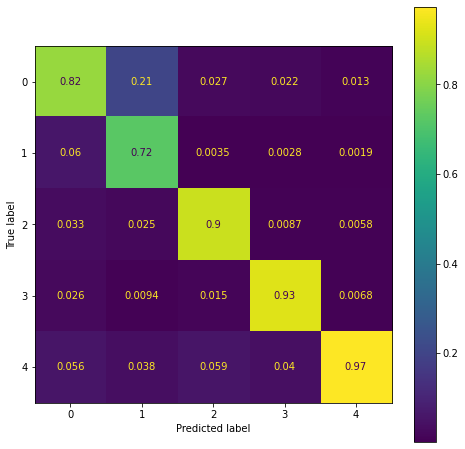

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(cat, X_test, y_test, ax=ax, 
                      include_values=True, normalize="pred", labels=np.arange(0,5))
plt.show()

**Выводы:** модель больше всего путается между классами 0 и 1, то есть между "Не спам" и "Небольшие полезные ИП / малые бизнесы". Скорее всего для абонентов эти 2 категории достаточно похожи и вторые в основном являются не спамом, а полезными звонками, поэтому модель в них путается.

Выведем confusion matrix для следующего дня

  0%|          | 0/1 [00:00<?, ?it/s]

F0.5: 0.80902 Precision: 0.83978 Recall: 0.72916


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


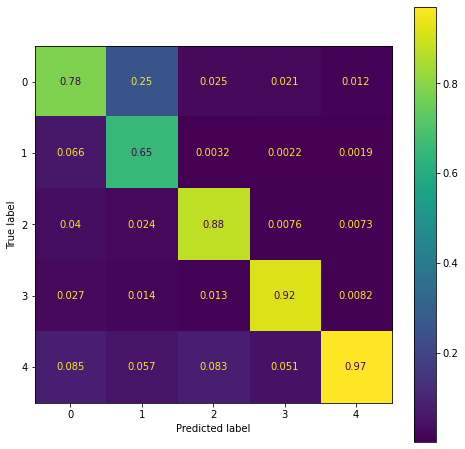

In [ ]:
df_test = get_first_n_days(1, 1)
test_target = df_test.target
test_data = df_test.loc[:, df_test.columns != 'target']
pred = cat.predict(test_data)
print("F0.5:", round(fbeta_score(test_target, pred, average='macro', beta=0.5), 5), 
      "Precision:", round(precision_score(test_target, pred, average='macro'), 5),  
      "Recall:", round(recall_score(test_target, pred, average='macro'), 5))
fig,ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(cat, test_data, test_target, ax=ax, 
                      include_values=True, normalize="pred", labels=np.arange(0,5))
plt.show()

**Выводы:** Заметно падение на 0.03 целевой метрики. Откуда можно сделать вывод, что данных одного дня для стабильного предсказания в следующие дни не достаточно. Поэтому будем искать достаточное количество дней для стабильного предсказания в дальнейшем.

# Обучение на первых N днях

Теперь будем обучать не на одном дне, а на N днях, где N - пробегает от 1 до 16. Посмотрим, как размер обучающей выборки будет влиять на качество предсказания в последующие дни. Для удобства обучения, мы распараллелили задачу на несколько видеокарт. Здесь мы приводим код обучения модели для фиксированного N.

In [ ]:
N=14

In [ ]:
df_train = get_first_n_days(N)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
train_target = df_train.target
train_data = df_train.loc[:, df_train.columns != 'target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data.values, 
                                                    train_target.values, 
                                                    train_size=0.8, 
                                                    random_state=666, 
                                                    shuffle = True)

In [ ]:
cat = CatBoostClassifier(iterations=1000, task_type='GPU',
                         devices='0', depth=8, learning_rate=0.25,
                         loss_function='MultiClass',
                         eval_metric = "Accuracy",
                         random_seed = 666,
                         use_best_model=True)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
pred = cat.predict(X_test)
print("F0.5:", round(fbeta_score(y_test, pred, average='macro', beta=0.5), 5), 
      "Precision:", round(precision_score(y_test, pred, average='macro'), 5),  
      "Recall:", round(recall_score(y_test, pred, average='macro'), 5))
imp=cat.get_feature_importance()
# for i in range(len(imp)):
#     if imp[i]!=0:
#         print(train_data.columns[i], imp[i])

0:	learn: 0.9007606	test: 0.9008375	best: 0.9008375 (0)	total: 455ms	remaining: 7m 34s
1:	learn: 0.9024868	test: 0.9025581	best: 0.9025581 (1)	total: 859ms	remaining: 7m 8s
2:	learn: 0.9065683	test: 0.9066483	best: 0.9066483 (2)	total: 1.24s	remaining: 6m 51s
3:	learn: 0.9054434	test: 0.9055085	best: 0.9066483 (2)	total: 1.64s	remaining: 6m 48s
4:	learn: 0.9053041	test: 0.9053406	best: 0.9066483 (2)	total: 2.02s	remaining: 6m 42s
5:	learn: 0.9099715	test: 0.9100380	best: 0.9100380 (5)	total: 2.42s	remaining: 6m 40s
6:	learn: 0.9104173	test: 0.9104965	best: 0.9104965 (6)	total: 2.79s	remaining: 6m 35s
7:	learn: 0.9104461	test: 0.9105158	best: 0.9105158 (7)	total: 3.15s	remaining: 6m 30s
8:	learn: 0.9117026	test: 0.9117395	best: 0.9117395 (8)	total: 3.57s	remaining: 6m 32s
9:	learn: 0.9172046	test: 0.9172877	best: 0.9172877 (9)	total: 3.91s	remaining: 6m 27s
10:	learn: 0.9200528	test: 0.9201758	best: 0.9201758 (10)	total: 4.28s	remaining: 6m 24s
11:	learn: 0.9199323	test: 0.9200704	best:

Сохраняем модели для дальнейшего тестирования и выбора лучшей.

In [ ]:
cat.save_model('/content/drive/My Drive/BestHack/models/first_'+str(N)+'_days.cbm', format="cbm")

# Визуализация после обучения

## Качество в зависимости от дня

Также распараллелим тестирование моделей на несколько видеокарт. Здесь приводим тестированиие на днях с 1 по 21.

In [ ]:
cat = CatBoostClassifier(iterations=1000, task_type='GPU',
                         devices='0', depth=8, learning_rate=0.25,
                         loss_function='MultiClass',
                         eval_metric = "Accuracy",
                         random_seed = 666,
                         use_best_model=True)
f_beta = np.zeros((len(names),16))
prec = np.zeros((len(names),16))
rec = np.zeros((len(names),16))
for i in tqdm(range(0,20)):
    df = pd.read_csv('/content/drive/My Drive/BestHack/transactions/'+names[i])
    df_train = get_first_n_days(1, start=i)
    train_target = df_train.target
    train_data = df_train.loc[:, df_train.columns != 'target']
    X_test = train_data.values
    y_test = train_target.values
    for j in range(16):
        cat.load_model('/content/drive/My Drive/BestHack/models/first_'+str(j+1)+'_days.cbm')
        pred = cat.predict(X_test)
        f_beta[i][j] = round(fbeta_score(y_test, pred, average='macro', beta=0.5), 5)
        prec[i][j] = round(precision_score(y_test, pred, average='macro'), 5)
        rec[i][j] = round(recall_score(y_test, pred, average='macro'), 5)
    with open('/content/drive/My Drive/BestHack/data/f_beta_1-16_days_part_1.npy', 'wb') as f:
        np.save(f, np.array(f_beta))
    with open('/content/drive/My Drive/BestHack/data/precision_1-16_days_part_1.npy', 'wb') as f:
        np.save(f, np.array(prec))
    with open('/content/drive/My Drive/BestHack/data/recall_1-16_days_part_1.npy', 'wb') as f:
        np.save(f, np.array(rec))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Теперь объединим результаты в один numpy-массив и посмотрим как выходные и праздники влияют на качество модели.

In [ ]:
with open('/content/drive/My Drive/BestHack/data/f_beta_1-16_days_part_1.npy', 'rb') as f:
    part_1 = np.load(f)[:20]
with open('/content/drive/My Drive/BestHack/data/f_beta_1-16_days_part_2.npy', 'rb') as f:
    part_2 = np.load(f)[20:42]
with open('/content/drive/My Drive/BestHack/data/f_beta_1-16_days_part_3.npy', 'rb') as f:
    part_3 = np.load(f)[42:]

In [ ]:
!ls /content/drive/My Drive/BestHack/data/

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/BestHack/data/': No such file or directory


In [ ]:
f_beta_61_days = np.concatenate([part_1, part_2, part_3], axis=0)

In [ ]:
# f_beta_7_days = np.load('/content/drive/My Drive/BestHack/data/f_beta_1-16_days.npy')
# precision = np.load('/content/drive/My Drive/BestHack/data/precision_1-16_days.npy')
# recall = np.load('/content/drive/My Drive/BestHack/data/recall_1-16_days.npy')

In [ ]:
sns.set(font_scale=1.3)
holidays = np.array([ 5, 6, 12, 13, 19, 20, 26, 27, 33, 34, 40, 41, 47, 48, 54, 55])
celebrity_days = np.array([3, 4, 59, 60])

  0%|          | 0/16 [00:00<?, ?it/s]

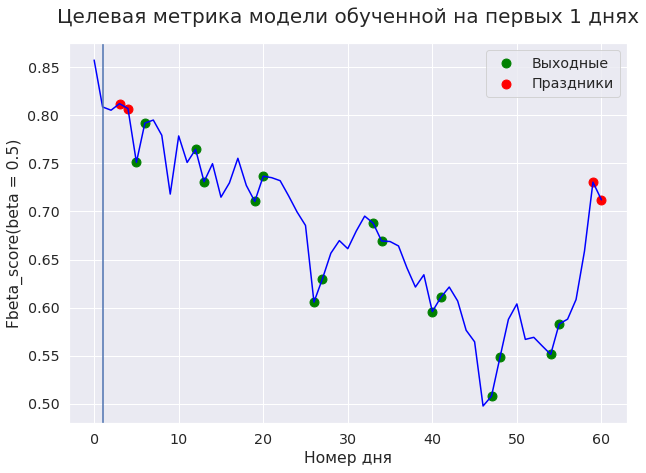

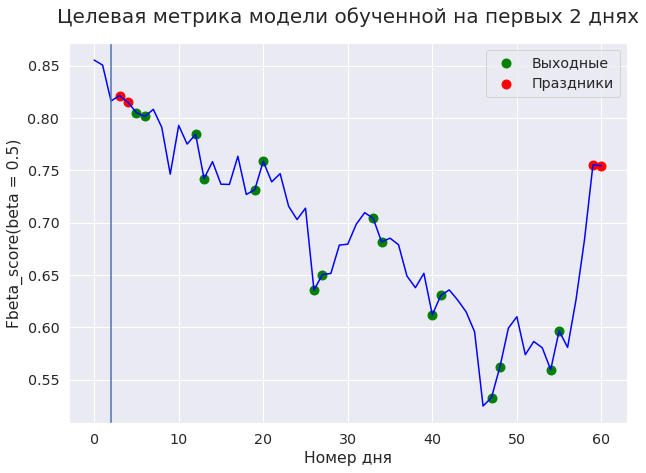

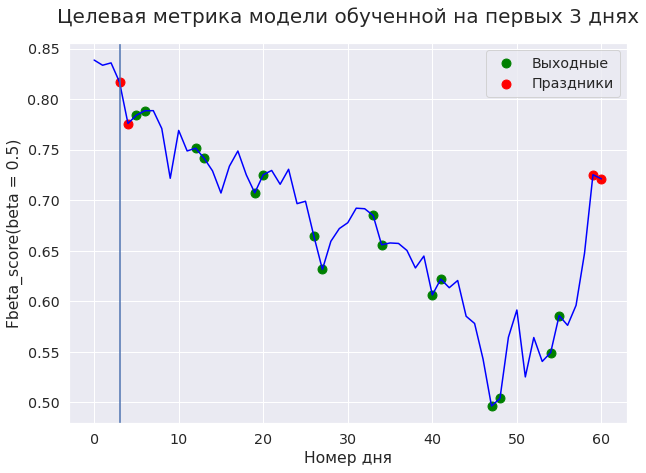

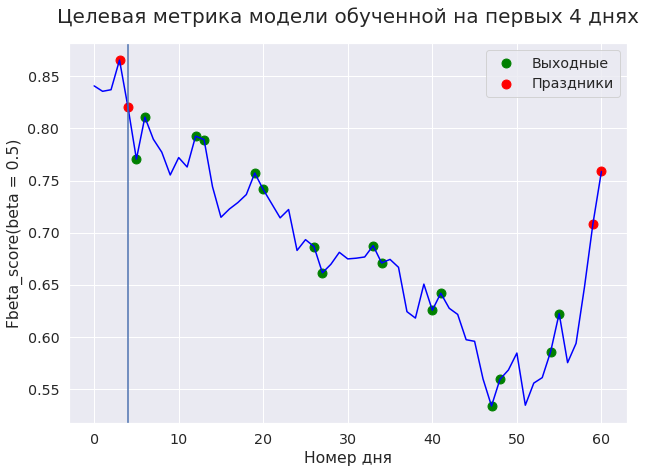

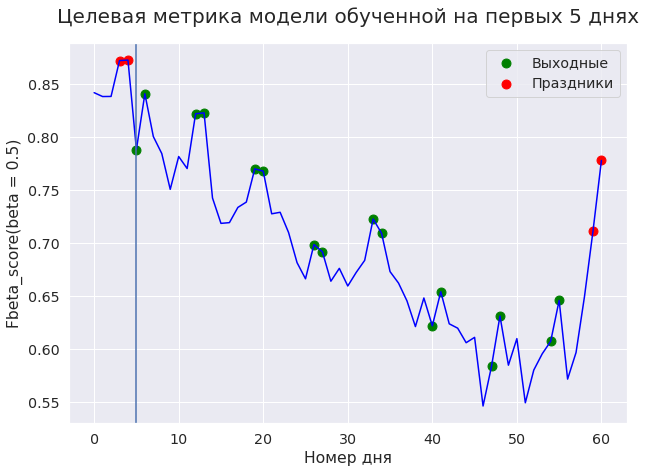

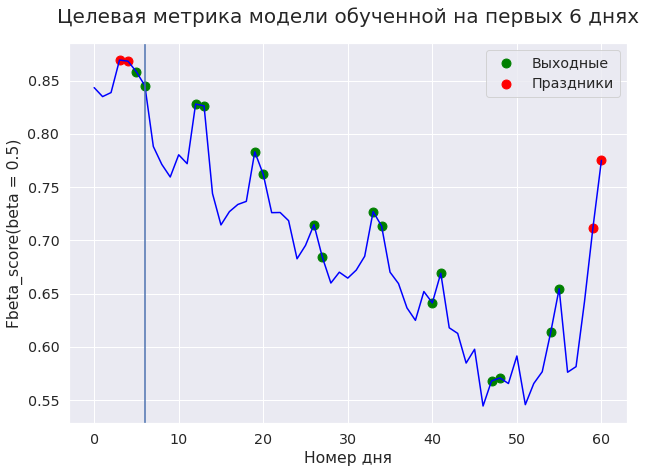

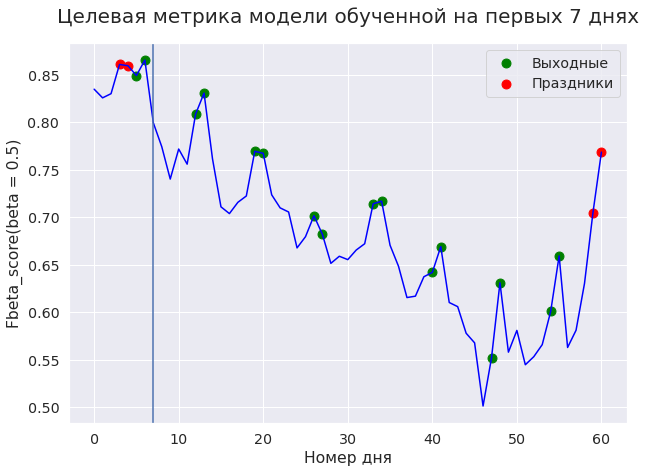

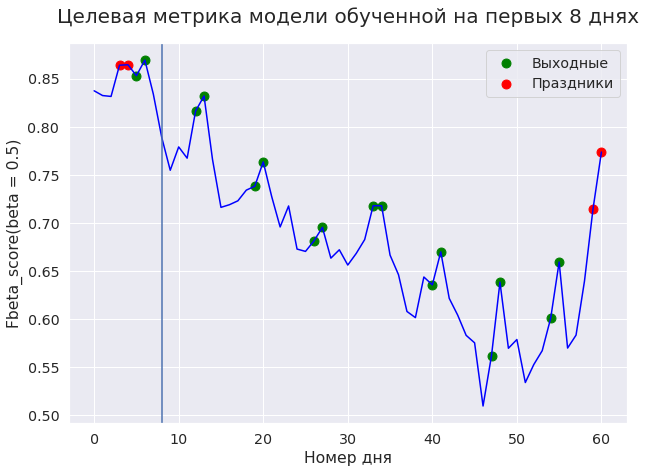

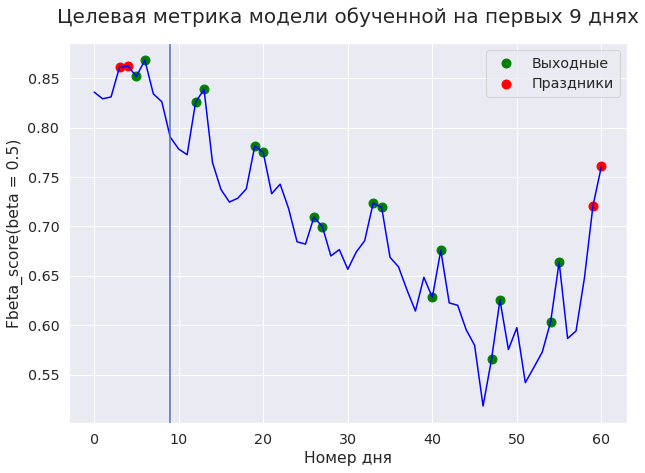

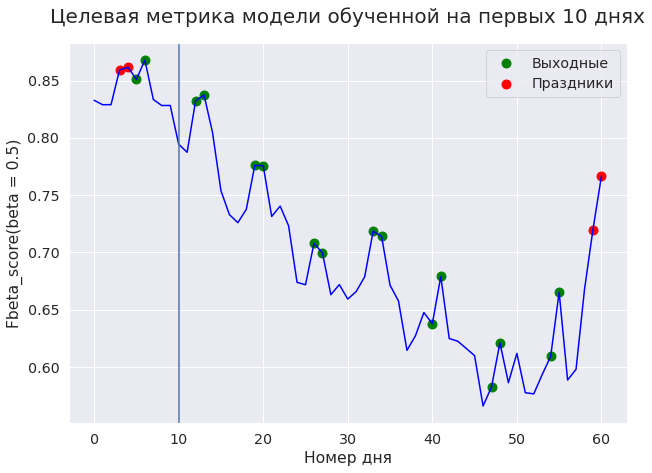

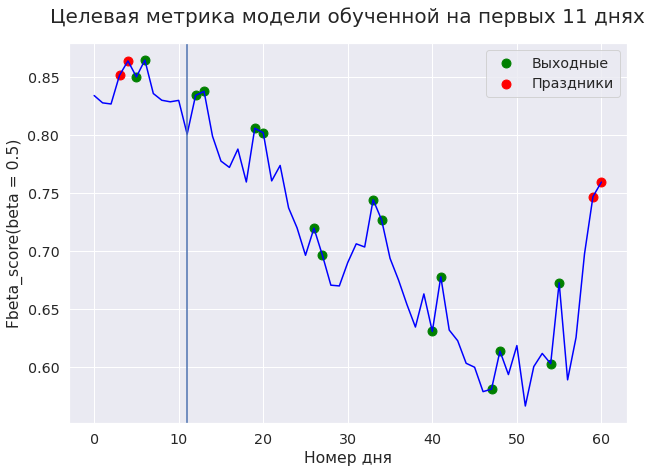

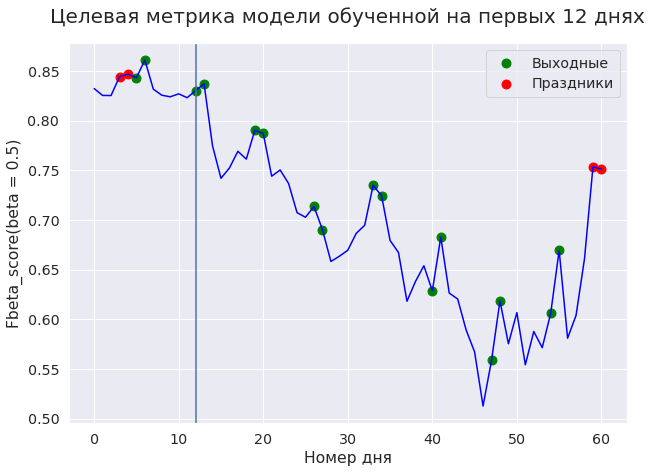

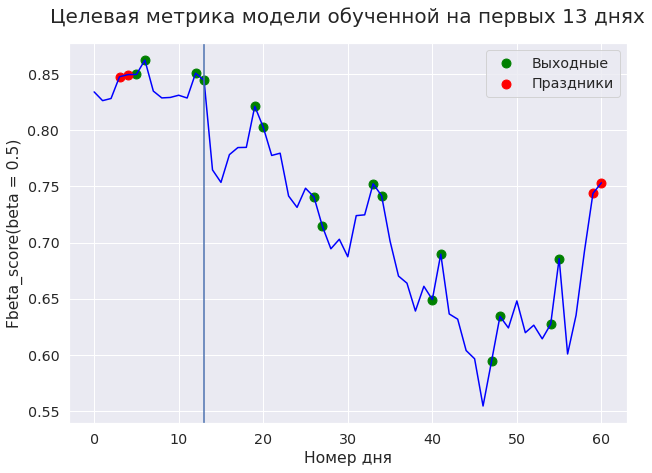

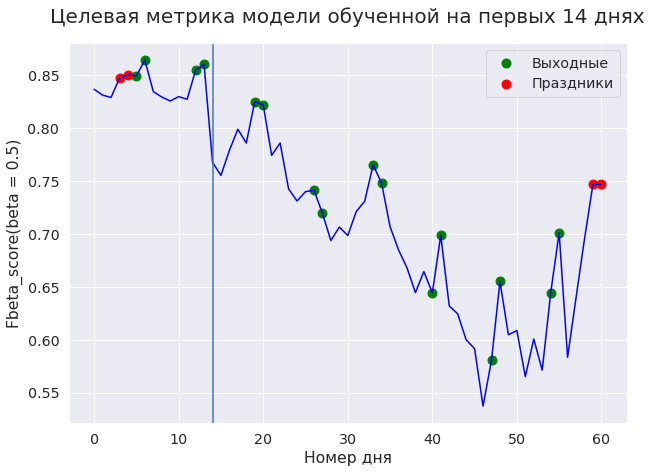

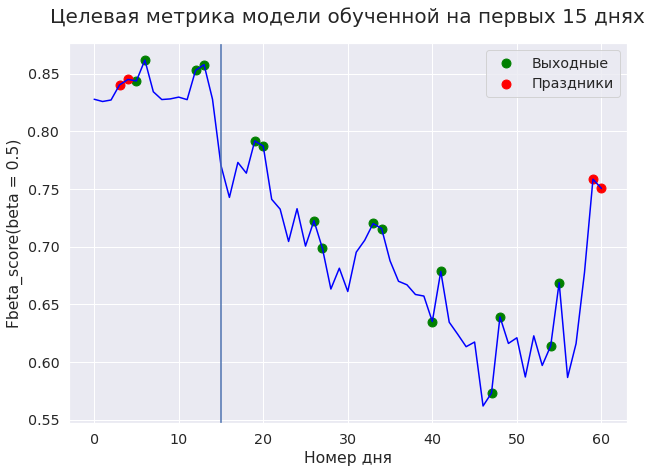

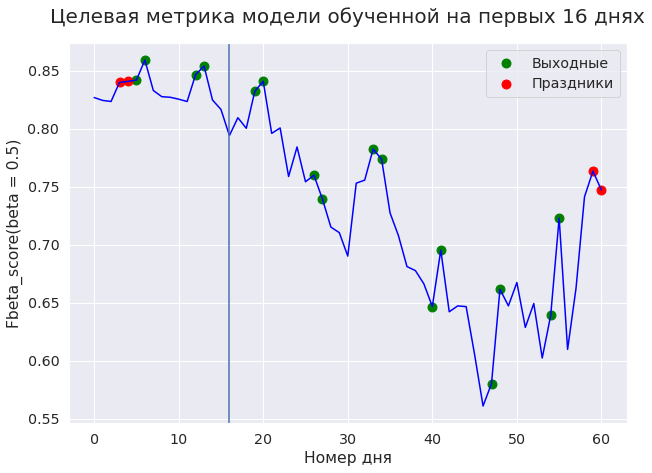

In [ ]:
for i in tqdm(range(16)):
    plt.figure(figsize = (10,7))
    plt.plot(f_beta_61_days[:,i], c = 'blue')
    plt.scatter(x = holidays, y = [f_beta_61_days[s][i] for s in holidays], color = 'green', s = 80, label = 'Выходные')
    plt.scatter(x = celebrity_days, y = [f_beta_61_days[s][i] for s in celebrity_days], color = 'red', s = 80, label = 'Праздники')
    plt.axvline(x=i+1)
    plt.xlabel('Номер дня')
    plt.ylabel('Fbeta_score(beta = 0.5)')
    plt.legend()
    plt.title(f"Целевая метрика модели обученной на первых {i+1} днях", fontsize = 20, pad = 20)
plt.show()

**Выводы:** Если обучаться на количестве дней меньше недели, то можно заметить, что качества предсказаний на выходных днях являются локальными **минимумами** графика F beta score. Если же брать больше недели(то есть обучаемся в том числе еще и на данных с выходных дней), качество становится заметно лучше и качества предсказаний на выходных днях являются локальными **максимумами** графика F beta score. По нашей оценке, самыми лучшими оказались модели, обученные на 14 и 16 днях. Для предсказаний на неразмеченных данных будем использовать модель обученную на 16 днях. Считая допустимым минимальным скором 0.75, модель может быть использована примерно в течении недели(7-9 дней).

## Значимость фичей

Посмотрим значимость каждой фичи:

In [ ]:
cat = CatBoostClassifier(iterations=1000, task_type='GPU',
                         devices='0', depth=8, learning_rate=0.25,
                         loss_function='MultiClass',
                         eval_metric = "Accuracy",
                         random_seed = 666,
                         use_best_model=True)
cat.load_model('/content/drive/My Drive/BestHack/models/first_16_days.cbm')
imp=cat.get_feature_importance()
feat_names = ["id_a", "id_b", "time_zone", "duration", "forward", "zero_call_flg", "source_b", "source_f", "minutes"]
for i in range(len(feat_names)):
    print(feat_names[i]+":",round(imp[i],5))

id_a: 62.67971
id_b: 0.07739
time_zone: 16.85319
duration: 9.74262
forward: 0.06655
zero_call_flg: 7.74096
source_b: 0.11777
source_f: 0.35336
minutes: 1.08971


Наиболее важная фича id_a - номер звонящего(очевидно, номер имеет ключевую роль для определения спамера, так как спамер звонит с определенного номера), также важны временная зона(то есть важно время суток, в которое звонят определенные категории), длительность звонка(как было сказано выше, со спамерами говорят сильно меньше среднего, а с мобильной каруселью - дольше среднего) и метка, имеет ли данный звонок нулевую длительность(спамеров обычно сбрасывают сразу и не отвечают, отсюда нулевая длительность). Значимость остальных фичей заметно ниже и они, вероятно, не сильно влияют на качество

# Качество модели на слабоактивных номерах

Будем говорить, что номера абонентов, которые звонят, слабоактивные, если за все дни датасета они звонили не более 62 раз, т.е. в среднем звонили по 1 разу в день.

Напишем функцию, которая для каждого номера абонента, который звонит, находит сколько раз он звонил за все дни в нашем датасете. Функция выводит словарь с ключом - номер абонента, который звонит, и со значением - количество его звонков

In [ ]:
def find_sick_numbers(i, d, names):
    df_i = pd.read_csv('/content/drive/My Drive/BestHack/transactions/'+names[i])
    dc = dict(df_i['id_a'].value_counts())
    for k, v in dc.items():
        if k in d:
            d[k] += v
        else:
            d[k] = v
    return d

Запишем в массив слабоактивных номеров те номера, число звонков с которых < 62

In [ ]:
d = {}
for i in tqdm(range(61)):
    d = find_sick_numbers(i, d, names)

dc = {k: v for k, v in sorted(d.items(), key=lambda item: item[1]) if v <= 61}
nms = list(dc.keys())

  0%|          | 0/61 [00:00<?, ?it/s]

Напишем функцию, которая выдает с гугл-диска данные из выбранного интервала времени(дни),  что номера абонентов, которые звонят, содержатся в массиве слабоактивных номеров

In [ ]:
def get_first_n_days_new(n, nms, start=0, names=names):
    df_target = pd.read_csv('/content/drive/My Drive/BestHack/target.csv')
    df_target = df_target.rename(columns={"id": "id_a"})
    df_train = []
    for i in tqdm(range(start, start+n)):
        df_i = pd.read_csv('/content/drive/My Drive/BestHack/transactions/'+names[i])
        df_train_i = pd.merge(df_i, df_target).dropna()
        df_train_i.drop('split', axis=1, inplace=True)
        df_train_i = df_train_i[df_train_i['id_a'].isin(nms)]
        df_train_i['hour'] = pd.to_datetime(df_train_i['start_time_local'], format="%H:%M:%S").dt.hour
        df_train_i['minutes'] = pd.to_datetime(df_train_i['start_time_local'], format="%H:%M:%S").dt.minute
        df_train_i['minutes'] += 60*df_train_i['hour']
        df_train_i.drop('hour', axis=1, inplace=True)
        df_train_i.drop('start_time_local', axis=1, inplace=True)
        df_train_i['dayofweek'] = pd.to_datetime(df_train_i['time_key']).dt.dayofweek
        df_train_i.drop('time_key', axis=1, inplace=True)
        df_train_i.drop('num_b_length', axis=1, inplace=True)
        df_train.append(df_train_i)
    return pd.concat(df_train)

In [ ]:
df_train = get_first_n_days_new(n = 61, nms = nms)

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
train_target = df_train.target
train_data = df_train.loc[:, df_train.columns != 'target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data.values, 
                                                    train_target.values, 
                                                    train_size=0.8, 
                                                    random_state=666, 
                                                    shuffle = True)

In [ ]:
cat = CatBoostClassifier(iterations=1000, task_type='GPU',
                         devices='0', depth=8, learning_rate=0.25,
                         loss_function='MultiClass',
                         eval_metric = "Accuracy",
                         random_seed = 666,
                         use_best_model=True)

Предскажем наш результат на заранее обученной моделе CatBoostClassifier, обученной на 16 днях

In [ ]:
cat.load_model('/content/drive/My Drive/BestHack/models/first_16_days.cbm')

In [ ]:
pred = cat.predict(X_test)
print("F0.5:", round(fbeta_score(y_test, pred, average='macro', beta=0.5), 5))

F0.5: 0.29475


Получили значения нашей целевой метрики, равное $0,29475$

Получим предсказания нашей модели

In [ ]:
pred1 = [s[0] for s in pred]

Text(0.5, 1.0, 'Распределение рассчитанных категорий пользователей')

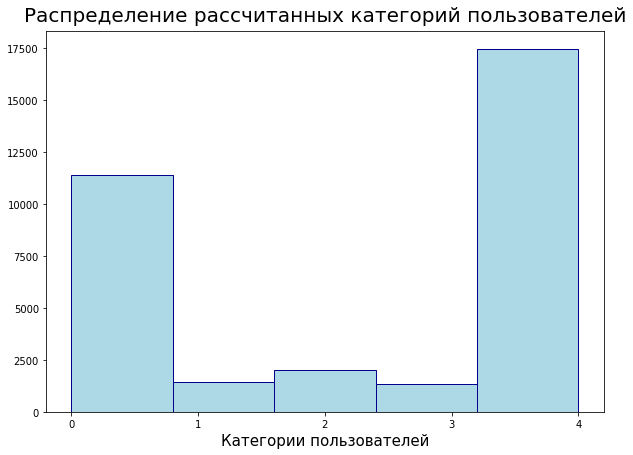

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pred1, ec="darkblue", fc="lightblue", bins=5)
plt.xticks(np.arange(5))
plt.xlabel("Категории пользователей", fontsize = 15)
plt.title("Распределение рассчитанных категорий пользователей", fontsize = 20, pad = 10)

**Вывод:** Больше всего наша модель предсказала пользователей категории 0 и 4, т.е. "не спамеров" и "черных спамеров и мошенников"

Text(0.5, 1.0, 'Распределение категорий пользователей')

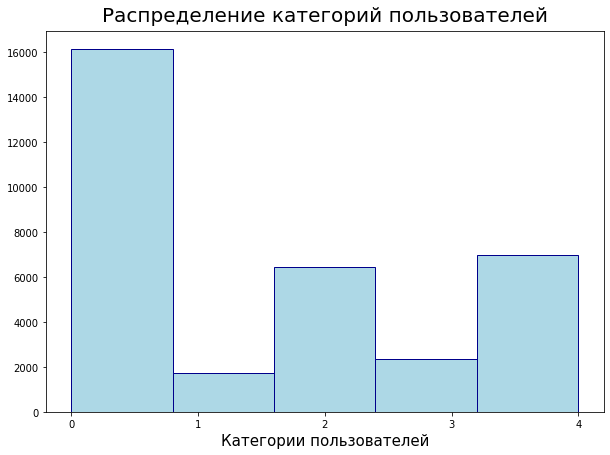

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(y_test, ec="darkblue", fc="lightblue", bins=5)
plt.xticks(np.arange(5))
plt.xlabel("Категории пользователей", fontsize = 15)
plt.title("Распределение категорий пользователей", fontsize = 20, pad = 10)

**Вывод:** Из исходного распределения видно, что больше всего было классов типа 0 (не спамер). Классов типа 2 и 4("организации" и " черные спамеры и мошенники") и классов типа 1 и 3("небольшие полезные ИП / малые бизнесы" и "мобильная карусель") было примерно одинаковое число

Посмотрим на confusion matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


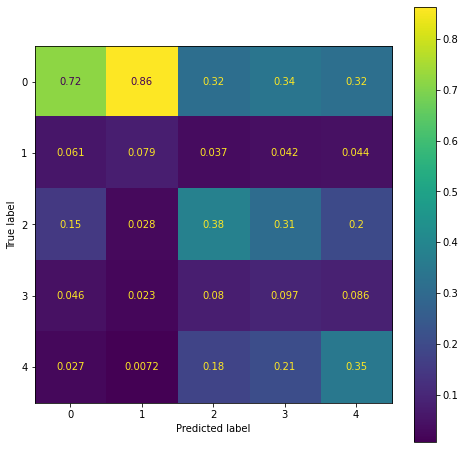

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(cat, train_data, train_target, ax=ax, 
                      include_values=True, normalize="pred", labels=np.arange(0,5))
plt.show()

**Вывод:** Видно, что очень часто для класса 0 мы предсказываем, что он из другого класса

# Предсказание для неразмеченной выборки

Для достижения максимального скора на неразмеченных данных лучше всего обучить модель на всех имеющихся 61 днях, однако ввиду ограниченности доступной для обучения видеопамяти, максимально можно обучить модель только на 16 днях. Также возможно было бы обучить несколько моделей на разные временные промежутки, но данный подход не соответствует поставленному заданию(необходимо использовать одну модель и для "прода", и для предсказания на неразмеченных данных). Поэтому предскажем нашей моделью вероятности принадлежности к каждому классу для всех обучающих данных и усредним предсказания. 

In [ ]:
cat = CatBoostClassifier(iterations=1000, task_type='GPU',
                         devices='0', depth=8, learning_rate=0.25,
                         loss_function='MultiClass',
                         eval_metric = "Accuracy",
                         random_seed = 666,
                         use_best_model=True)
cat.load_model('/content/drive/My Drive/BestHack/models/first_16_days.cbm')

In [ ]:
df_target = pd.read_csv('/content/drive/My Drive/BestHack/target.csv')

In [ ]:
answers={str(i):[np.array([0,0,0,0,0]), 0] for i in df_target[df_target.split=="test"].id.values}

In [ ]:
n=61
df_target = pd.read_csv('/content/drive/My Drive/BestHack/target.csv')
df_target = df_target.rename(columns={"id": "id_a"})
for i in tqdm(range(61)):
    df_i = pd.read_csv('/content/drive/My Drive/BestHack/transactions/'+names[i])
    df_train_i = pd.merge(df_i, df_target)
    df_train_i = df_train_i[df_train_i.split=="test"]
    df_train_i.drop('split', axis=1, inplace=True)
    df_train_i['hour'] = pd.to_datetime(df_train_i['start_time_local'], format="%H:%M:%S").dt.hour
    df_train_i['minutes'] = pd.to_datetime(df_train_i['start_time_local'], format="%H:%M:%S").dt.minute
    df_train_i['minutes'] += 60*df_train_i['hour']
    df_train_i.drop('hour', axis=1, inplace=True)
    df_train_i.drop('start_time_local', axis=1, inplace=True)
    df_train_i['dayofweek'] = pd.to_datetime(df_train_i['time_key']).dt.dayofweek
    df_train_i.drop('time_key', axis=1, inplace=True)
    df_train_i.drop('num_b_length', axis=1, inplace=True)
    ids = df_train_i.id_a.values
    train_data = df_train_i.loc[:, df_train_i.columns != 'target'].values
    pred = cat.predict_proba(train_data)
    for j in range(len(ids)):
        answers[str(ids[j])][0]=answers[str(ids[j])][0]+np.array(pred[j])
        answers[str(ids[j])][1]+=1

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
for key in answers.keys():
    answers[key] = answers[key][0]/answers[key][1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
answers_keys = []
answers_values = []
for key in answers.keys():
    answers_keys.append(int(key))
    answers_values.append(answers[key])

In [ ]:
df_target.loc[df_target['target'].isna() == True, ['target']] = pd.Series(np.array(answers_values).argmax(axis=1), name="target")

In [ ]:
df_target.to_csv("/content/drive/My Drive/BestHack/beeline_hakaton_team_3_submit.csv")